Colab Link: https://colab.research.google.com/drive/1lTHjbc0MwqIWErs7wm8Huue3NqVH3Q8s?usp=sharing

# Data Downloads and Imports

In [0]:
# Download Ground Truth Depths
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_depth_annotated.zip
!unzip data_depth_annotated.zip
!rm data_depth_annotated.zip
!rm -r train

In [0]:
# Download the Images
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0002/2011_09_26_drive_0002_sync.zip
!unzip 2011_09_26_drive_0002_sync.zip

# Download the Pretrained Model
!wget https://cogaplex-bts.s3.ap-northeast-2.amazonaws.com/bts_eigen_v2_pytorch_resnet50.zip
!unzip bts_eigen_v2_pytorch_resnet50.zip

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from numba import njit
import math
import time
import cv2

from skimage.feature import plot_matches, match_descriptors
import plotly.express as px
import pandas as pd

# Image Processing

## Depth Estimation

### BTS Model

In [0]:
class atrous_conv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation, apply_bn_first=True):
        super(atrous_conv, self).__init__()
        self.atrous_conv = torch.nn.Sequential()
        if apply_bn_first:
            self.atrous_conv.add_module('first_bn', nn.BatchNorm2d(in_channels, momentum=0.01, affine=True, track_running_stats=True, eps=1.1e-5))
        
        self.atrous_conv.add_module('aconv_sequence', nn.Sequential(nn.ReLU(),
                                                                    nn.Conv2d(in_channels=in_channels, out_channels=out_channels*2, bias=False, kernel_size=1, stride=1, padding=0),
                                                                    nn.BatchNorm2d(out_channels*2, momentum=0.01, affine=True, track_running_stats=True),
                                                                    nn.ReLU(),
                                                                    nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels, bias=False, kernel_size=3, stride=1,
                                                                              padding=(dilation, dilation), dilation=dilation)))

    def forward(self, x):
        return self.atrous_conv.forward(x)
    
class upconv(nn.Module):
    def __init__(self, in_channels, out_channels, ratio=2):
        super(upconv, self).__init__()
        self.elu = nn.ELU()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, bias=False, kernel_size=3, stride=1, padding=1)
        self.ratio = ratio
        
    def forward(self, x):
        up_x = F.interpolate(x, scale_factor=self.ratio, mode='nearest')
        out = self.conv(up_x)
        out = self.elu(out)
        return out

class reduction_1x1(nn.Sequential):
    def __init__(self, num_in_filters, num_out_filters, max_depth, is_final=False):
        super(reduction_1x1, self).__init__()        
        self.max_depth = max_depth
        self.is_final = is_final
        self.sigmoid = nn.Sigmoid()
        self.reduc = torch.nn.Sequential()
        
        while num_out_filters >= 4:
            if num_out_filters < 8:
                if self.is_final:
                    self.reduc.add_module('final', torch.nn.Sequential(nn.Conv2d(num_in_filters, out_channels=1, bias=False,
                                                                                 kernel_size=1, stride=1, padding=0),
                                                                       nn.Sigmoid()))
                else:
                    self.reduc.add_module('plane_params', torch.nn.Conv2d(num_in_filters, out_channels=3, bias=False,
                                                                          kernel_size=1, stride=1, padding=0))
                break
            else:
                self.reduc.add_module('inter_{}_{}'.format(num_in_filters, num_out_filters),
                                      torch.nn.Sequential(nn.Conv2d(in_channels=num_in_filters, out_channels=num_out_filters,
                                                                    bias=False, kernel_size=1, stride=1, padding=0),
                                                          nn.ELU()))

            num_in_filters = num_out_filters
            num_out_filters = num_out_filters // 2
    
    def forward(self, net):
        net = self.reduc.forward(net)
        if not self.is_final:
            theta = self.sigmoid(net[:, 0, :, :]) * math.pi / 3
            phi = self.sigmoid(net[:, 1, :, :]) * math.pi * 2
            dist = self.sigmoid(net[:, 2, :, :]) * self.max_depth
            n1 = torch.mul(torch.sin(theta), torch.cos(phi)).unsqueeze(1)
            n2 = torch.mul(torch.sin(theta), torch.sin(phi)).unsqueeze(1)
            n3 = torch.cos(theta).unsqueeze(1)
            n4 = dist.unsqueeze(1)
            net = torch.cat([n1, n2, n3, n4], dim=1)
        
        return net

class local_planar_guidance(nn.Module):
    def __init__(self, upratio):
        super(local_planar_guidance, self).__init__()
        self.upratio = upratio
        self.u = torch.arange(self.upratio).reshape([1, 1, self.upratio]).float()
        self.v = torch.arange(int(self.upratio)).reshape([1, self.upratio, 1]).float()
        self.upratio = float(upratio)

    def forward(self, plane_eq, focal):
        plane_eq_expanded = torch.repeat_interleave(plane_eq, int(self.upratio), 2)
        plane_eq_expanded = torch.repeat_interleave(plane_eq_expanded, int(self.upratio), 3)
        n1 = plane_eq_expanded[:, 0, :, :]
        n2 = plane_eq_expanded[:, 1, :, :]
        n3 = plane_eq_expanded[:, 2, :, :]
        n4 = plane_eq_expanded[:, 3, :, :]
        
        u = self.u.repeat(plane_eq.size(0), plane_eq.size(2) * int(self.upratio), plane_eq.size(3)).cuda()
        u = (u - (self.upratio - 1) * 0.5) / self.upratio
        
        v = self.v.repeat(plane_eq.size(0), plane_eq.size(2), plane_eq.size(3) * int(self.upratio)).cuda()
        v = (v - (self.upratio - 1) * 0.5) / self.upratio

        return n4 / (n1 * u + n2 * v + n3)

class bts(nn.Module):
    def __init__(self, max_depth, feat_out_channels, num_features=512):
        super(bts, self).__init__()
        self.max_depth = max_depth

        self.upconv5    = upconv(feat_out_channels[4], num_features)
        self.bn5        = nn.BatchNorm2d(num_features, momentum=0.01, affine=True, eps=1.1e-5)
        
        self.conv5      = torch.nn.Sequential(nn.Conv2d(num_features + feat_out_channels[3], num_features, 3, 1, 1, bias=False),
                                              nn.ELU())
        self.upconv4    = upconv(num_features, num_features // 2)
        self.bn4        = nn.BatchNorm2d(num_features // 2, momentum=0.01, affine=True, eps=1.1e-5)
        self.conv4      = torch.nn.Sequential(nn.Conv2d(num_features // 2 + feat_out_channels[2], num_features // 2, 3, 1, 1, bias=False),
                                              nn.ELU())
        self.bn4_2      = nn.BatchNorm2d(num_features // 2, momentum=0.01, affine=True, eps=1.1e-5)
        
        self.daspp_3    = atrous_conv(num_features // 2, num_features // 4, 3, apply_bn_first=False)
        self.daspp_6    = atrous_conv(num_features // 2 + num_features // 4 + feat_out_channels[2], num_features // 4, 6)
        self.daspp_12   = atrous_conv(num_features + feat_out_channels[2], num_features // 4, 12)
        self.daspp_18   = atrous_conv(num_features + num_features // 4 + feat_out_channels[2], num_features // 4, 18)
        self.daspp_24   = atrous_conv(num_features + num_features // 2 + feat_out_channels[2], num_features // 4, 24)
        self.daspp_conv = torch.nn.Sequential(nn.Conv2d(num_features + num_features // 2 + num_features // 4, num_features // 4, 3, 1, 1, bias=False),
                                              nn.ELU())
        self.reduc8x8   = reduction_1x1(num_features // 4, num_features // 4, self.max_depth)
        self.lpg8x8     = local_planar_guidance(8)
        
        self.upconv3    = upconv(num_features // 4, num_features // 4)
        self.bn3        = nn.BatchNorm2d(num_features // 4, momentum=0.01, affine=True, eps=1.1e-5)
        self.conv3      = torch.nn.Sequential(nn.Conv2d(num_features // 4 + feat_out_channels[1] + 1, num_features // 4, 3, 1, 1, bias=False),
                                              nn.ELU())
        self.reduc4x4   = reduction_1x1(num_features // 4, num_features // 8, self.max_depth)
        self.lpg4x4     = local_planar_guidance(4)
        
        self.upconv2    = upconv(num_features // 4, num_features // 8)
        self.bn2        = nn.BatchNorm2d(num_features // 8, momentum=0.01, affine=True, eps=1.1e-5)
        self.conv2      = torch.nn.Sequential(nn.Conv2d(num_features // 8 + feat_out_channels[0] + 1, num_features // 8, 3, 1, 1, bias=False),
                                              nn.ELU())
        
        self.reduc2x2   = reduction_1x1(num_features // 8, num_features // 16, self.max_depth)
        self.lpg2x2     = local_planar_guidance(2)
        
        self.upconv1    = upconv(num_features // 8, num_features // 16)
        self.reduc1x1   = reduction_1x1(num_features // 16, num_features // 32, self.max_depth, is_final=True)
        self.conv1      = torch.nn.Sequential(nn.Conv2d(num_features // 16 + 4, num_features // 16, 3, 1, 1, bias=False),
                                              nn.ELU())
        self.get_depth  = torch.nn.Sequential(nn.Conv2d(num_features // 16, 1, 3, 1, 1, bias=False),
                                              nn.Sigmoid())

    def forward(self, features, focal):
        skip0, skip1, skip2, skip3 = features[1], features[2], features[3], features[4]
        dense_features = torch.nn.ReLU()(features[5])
        upconv5 = self.upconv5(dense_features) # H/16
        upconv5 = self.bn5(upconv5)
        concat5 = torch.cat([upconv5, skip3], dim=1)
        iconv5 = self.conv5(concat5)
        
        upconv4 = self.upconv4(iconv5) # H/8
        upconv4 = self.bn4(upconv4)
        concat4 = torch.cat([upconv4, skip2], dim=1)
        iconv4 = self.conv4(concat4)
        iconv4 = self.bn4_2(iconv4)
        
        daspp_3 = self.daspp_3(iconv4)
        concat4_2 = torch.cat([concat4, daspp_3], dim=1)
        daspp_6 = self.daspp_6(concat4_2)
        concat4_3 = torch.cat([concat4_2, daspp_6], dim=1)
        daspp_12 = self.daspp_12(concat4_3)
        concat4_4 = torch.cat([concat4_3, daspp_12], dim=1)
        daspp_18 = self.daspp_18(concat4_4)
        concat4_5 = torch.cat([concat4_4, daspp_18], dim=1)
        daspp_24 = self.daspp_24(concat4_5)
        concat4_daspp = torch.cat([iconv4, daspp_3, daspp_6, daspp_12, daspp_18, daspp_24], dim=1)
        daspp_feat = self.daspp_conv(concat4_daspp)
        
        reduc8x8 = self.reduc8x8(daspp_feat)
        plane_normal_8x8 = reduc8x8[:, :3, :, :]
        plane_normal_8x8 = F.normalize(plane_normal_8x8, 2, 1)
        plane_dist_8x8 = reduc8x8[:, 3, :, :]
        plane_eq_8x8 = torch.cat([plane_normal_8x8, plane_dist_8x8.unsqueeze(1)], 1)
        depth_8x8 = self.lpg8x8(plane_eq_8x8, focal)
        depth_8x8_scaled = depth_8x8.unsqueeze(1) / self.max_depth
        depth_8x8_scaled_ds = F.interpolate(depth_8x8_scaled, scale_factor=0.25, mode='nearest')
        
        upconv3 = self.upconv3(daspp_feat) # H/4
        upconv3 = self.bn3(upconv3)
        concat3 = torch.cat([upconv3, skip1, depth_8x8_scaled_ds], dim=1)
        iconv3 = self.conv3(concat3)
        
        reduc4x4 = self.reduc4x4(iconv3)
        plane_normal_4x4 = reduc4x4[:, :3, :, :]
        plane_normal_4x4 = F.normalize(plane_normal_4x4, 2, 1)
        plane_dist_4x4 = reduc4x4[:, 3, :, :]
        plane_eq_4x4 = torch.cat([plane_normal_4x4, plane_dist_4x4.unsqueeze(1)], 1)
        depth_4x4 = self.lpg4x4(plane_eq_4x4, focal)
        depth_4x4_scaled = depth_4x4.unsqueeze(1) / self.max_depth
        depth_4x4_scaled_ds = F.interpolate(depth_4x4_scaled, scale_factor=0.5, mode='nearest')
        
        upconv2 = self.upconv2(iconv3) # H/2
        upconv2 = self.bn2(upconv2)
        concat2 = torch.cat([upconv2, skip0, depth_4x4_scaled_ds], dim=1)
        iconv2 = self.conv2(concat2)
        
        reduc2x2 = self.reduc2x2(iconv2)
        plane_normal_2x2 = reduc2x2[:, :3, :, :]
        plane_normal_2x2 = F.normalize(plane_normal_2x2, 2, 1)
        plane_dist_2x2 = reduc2x2[:, 3, :, :]
        plane_eq_2x2 = torch.cat([plane_normal_2x2, plane_dist_2x2.unsqueeze(1)], 1)
        depth_2x2 = self.lpg2x2(plane_eq_2x2, focal)
        depth_2x2_scaled = depth_2x2.unsqueeze(1) / self.max_depth
        
        upconv1 = self.upconv1(iconv2)
        reduc1x1 = self.reduc1x1(upconv1)
        concat1 = torch.cat([upconv1, reduc1x1, depth_2x2_scaled, depth_4x4_scaled, depth_8x8_scaled], dim=1)
        iconv1 = self.conv1(concat1)
        final_depth = self.max_depth * self.get_depth(iconv1)
        final_depth = final_depth * focal.view(-1, 1, 1, 1).float() / 715.0873
        
        return depth_8x8_scaled, depth_4x4_scaled, depth_2x2_scaled, reduc1x1, final_depth

class encoder(nn.Module):
    def __init__(self, encoder_type):
        super(encoder, self).__init__()
        self.encoder_type = encoder_type
        import torchvision.models as models
        if self.encoder_type == 'densenet121_bts':
            self.base_model = models.densenet121(pretrained=True).features
            self.feat_names = ['relu0', 'pool0', 'transition1', 'transition2', 'norm5']
            self.feat_out_channels = [64, 64, 128, 256, 1024]
        elif self.encoder_type == 'densenet161_bts':
            self.base_model = models.densenet161(pretrained=True).features
            self.feat_names = ['relu0', 'pool0', 'transition1', 'transition2', 'norm5']
            self.feat_out_channels = [96, 96, 192, 384, 2208]
        elif self.encoder_type == 'resnet50_bts':
            self.base_model = models.resnet50(pretrained=True)
            self.feat_names = ['relu', 'layer1', 'layer2', 'layer3', 'layer4']
            self.feat_out_channels = [64, 256, 512, 1024, 2048]
        elif self.encoder_type == 'resnet101_bts':
            self.base_model = models.resnet101(pretrained=True)
            self.feat_names = ['relu', 'layer1', 'layer2', 'layer3', 'layer4']
            self.feat_out_channels = [64, 256, 512, 1024, 2048]
        elif self.encoder_type == 'resnext50_bts':
            self.base_model = models.resnext50_32x4d(pretrained=True)
            self.feat_names = ['relu', 'layer1', 'layer2', 'layer3', 'layer4']
            self.feat_out_channels = [64, 256, 512, 1024, 2048]
        elif self.encoder_type == 'resnext101_bts':
            self.base_model = models.resnext101_32x8d(pretrained=True)
            self.feat_names = ['relu', 'layer1', 'layer2', 'layer3', 'layer4']
            self.feat_out_channels = [64, 256, 512, 1024, 2048]
        else:
            print('Not supported encoder: {}'.format(self.encoder_type))

    def forward(self, x):
        features = [x]
        skip_feat = [x]
        for k, v in self.base_model._modules.items():
            if 'fc' in k or 'avgpool' in k:
                continue
            feature = v(features[-1])
            features.append(feature)
            if any(x in k for x in self.feat_names):
                skip_feat.append(feature)
        
        return skip_feat
    
class BtsModel(nn.Module):
    def __init__(self, max_depth, encoder_type, bts_size):
        super(BtsModel, self).__init__()
        self.encoder = encoder(encoder_type)
        self.decoder = bts(max_depth, self.encoder.feat_out_channels, bts_size)

    def forward(self, x, focal):
        skip_feat = self.encoder(x)
        return self.decoder(skip_feat, focal)
    

### Estimator Class

In [0]:
class DepthEstimator():

    def __init__(self, checkpoint_path = '/content/bts_eigen_v2_pytorch_resnet50/model', do_kb_crop = True, do_image_plot = False, encoder_type = 'resnet50_bts'):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.focal = 9.597910e+02 # 721.5377
        self.do_kb_crop = do_kb_crop
        self.do_image_plot = do_image_plot

        self.max_depth = 80
        self.encoder_type = encoder_type
        self.bts_size = 512
        self.checkpoint_path = checkpoint_path

        model = nn.DataParallel(BtsModel(self.max_depth, self.encoder_type, self.bts_size))
        checkpoint = torch.load(self.checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        model.eval()
        model.cuda()
        self.model = model.module

    def kb_crop(self, image):
        height = image.shape[0]
        width = image.shape[1]
        top_margin = int(height - 352)
        left_margin = int((width - 1216) / 2)
        image = image[top_margin:top_margin + 352, left_margin:left_margin + 1216, :]
        return image, top_margin, left_margin

    def __call__(self, image, return_margins = False):

        if self.do_kb_crop: image, top_margin, left_margin = self.kb_crop(image)
        else: image, top_margin, left_margin = image, 0, 0
        image_tensor = self.normalize(self.to_tensor(image))

        with torch.no_grad():
            image_tensor = Variable(image_tensor.unsqueeze(0)).cuda()
            focal = Variable(torch.tensor([self.focal])).cuda()
            _, _, _, _, depth_est = self.model(image_tensor, focal)

        depth_est = depth_est.cpu().numpy().squeeze()
        if self.do_image_plot: self.plot_image(image); self.plot_image(depth_est)

        if return_margins: return image, depth_est, top_margin, left_margin
        return image, depth_est
    
    def plot_image(self, image): plt.figure(figsize=(20,7)); plt.imshow(image, cmap='inferno_r'); plt.show()

    def to_tensor(self, image): return torch.from_numpy(image.transpose((2, 0, 1)))

### Testing

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



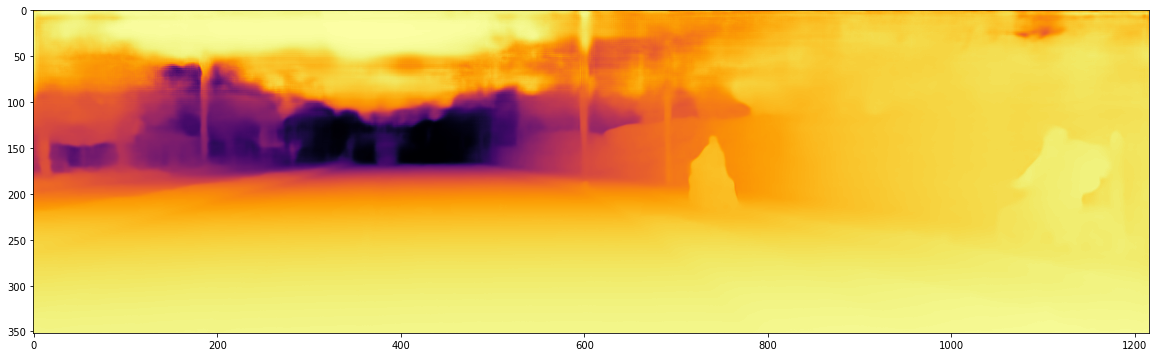

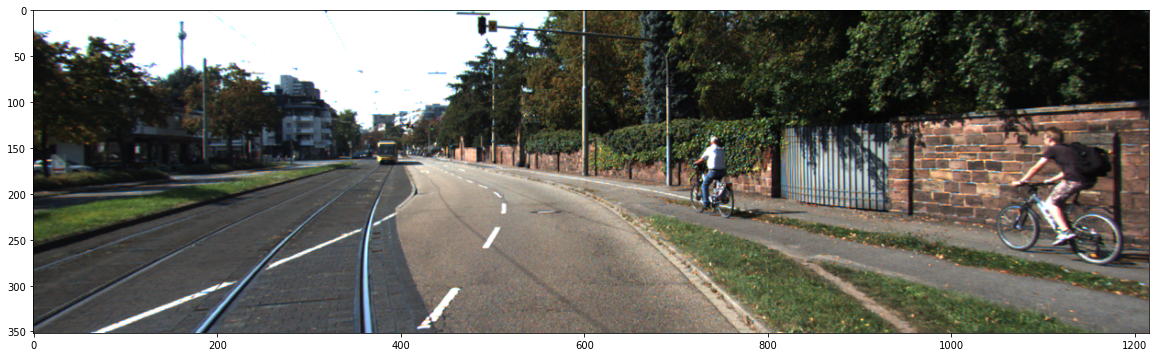

In [0]:
img_num = '05'
image_path = f'/content/2011_09_26/2011_09_26_drive_0002_sync/image_02/data/00000000{img_num}.png'
image = np.asarray(Image.open(image_path), dtype=np.float32) / 255.0

depth_estimator = DepthEstimator()
cropped_image, depth_est, top_margin, left_margin = depth_estimator(image, return_margins = True)
depth_estimator.plot_image(depth_est)
depth_estimator.plot_image(cropped_image)

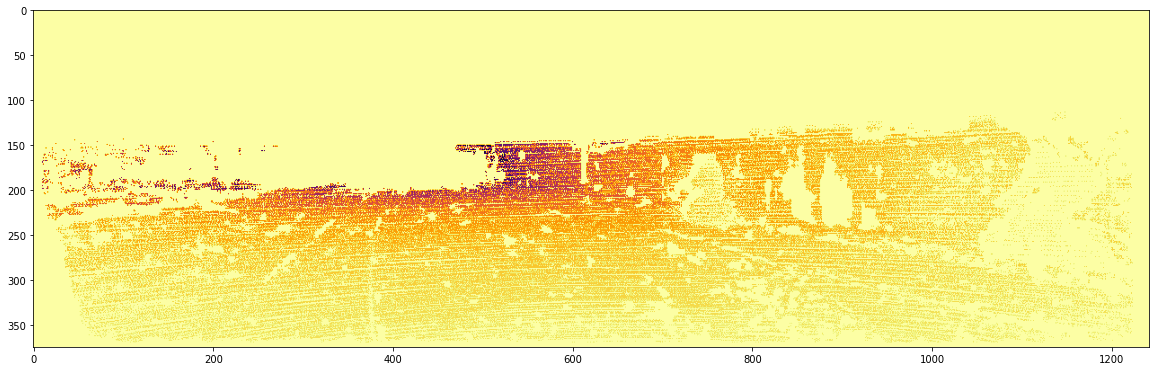

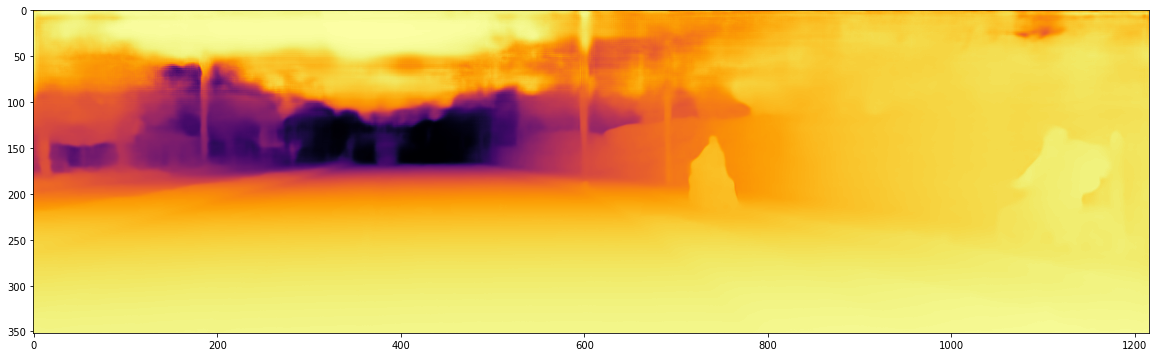

In [0]:
ground_truth_path = f'/content/val/2011_09_26_drive_0002_sync/proj_depth/groundtruth/image_02/00000000{img_num}.png'
ground_truth = np.asarray(Image.open(ground_truth_path), dtype = np.float32) / 256
ground_truth[top_margin:top_margin + 352, left_margin:left_margin + 1216]
depth_estimator.plot_image(ground_truth)
depth_estimator.plot_image(depth_est)

## ORB 

### ORB Code

In [0]:
bresenham_circle = np.array([[-3,0], [-3,1],  [-2,2],  [-1,3],
                              [0,3],  [1,3],   [2,2],   [3,1],
                              [3,0],  [3,-1],  [2,-2],  [1,-3],
                              [0,-3], [-1,-3], [-2,-2], [-3,-1]])
harris_k = 0.04 

@njit
def get_FAST(img, n = 9, threshold = 0.15):
    width = img.shape[0]
    height = img.shape[1]
    result = []
    
    for i in range(4,width-4):
        for j in range(4,height-4):
            corner = eval_FAST9(img, i, j, n, threshold)
            if corner == 1:
                result.append([i,j])
                
    return np.array(result)
            
@njit
def eval_FAST9(img, x0, y0, n, threshold):
    first_value = 0
    first_count = 0
    first_track = True
    
    current_count = 0
    current_value = 0
    
    for i in range(16):
        x,y = bresenham_circle[i]
        x,y = x+x0, y+y0
        dif = check_thresh(img[x0,y0], img[x,y], threshold)
        if i == 0:
            if dif == 0: first_track = False
            else:
                first_count = 1
                current_count = 1
                first_value = dif
                current_value = dif
        else:
            if dif == 0:
                current_count = 0
                current_value = 0  
                first_track = False
            elif dif != current_value:
                current_count = 1
                current_value = dif
                first_track = False
            elif dif == current_value:
                current_count = current_count + 1
                if first_track: first_count = first_count + 1
            
                
        if i == 15 and first_value == current_value: current_count = current_count + first_count
            
        if current_count >= n:
            return 1
        
    return 0  
    
@njit
def check_thresh(baseline, value, threshold):
    if   baseline - value > threshold:
        return -1
    elif value - baseline > threshold:
        return  1
    else:
        return 0

@njit
def harris_value(img, w_size, x0, y0):
    Ix = get_Ix(img, w_size, x0, y0)
    Iy = get_Iy(img, w_size, x0, y0)
    
    Ix2 = np.sum(Ix * Ix)
    Iy2 = np.sum(Iy * Iy)
    Ixy = np.sum(Ix * Iy)
    
    det = Ix2 * Iy2 - Ixy * Ixy
    trace = Ix2 + Iy2
    
    return det - harris_k * (trace ** 2)
    
@njit 
def get_Ix(img, w_size, x0, y0):
    result = np.zeros((2*w_size+1, 2*w_size+1))
    x0 = x0 - w_size
    y0 = y0 - w_size
    for i in range(2*w_size+1):
        for j in range(2*w_size+1):
            x,y = x0 + i, y0 + j
            result[i,j] = ((img[x+1,y] - img[x-1,y])/2) ** 2
    return result

@njit 
def get_Iy(img, w_size, x0, y0):
    result = np.zeros((2*w_size+1, 2*w_size+1))
    x0 = x0 - w_size
    y0 = y0 - w_size
    for i in range(2*w_size+1):
        for j in range(2*w_size+1):
            x,y = x0 + i, y0 + j
            result[i,j] = ((img[x,y+1] - img[x,y-1])/2) ** 2
    return result

@njit
def nFAST9(img, n, threshold):
    fast_points = get_FAST(img, n = 9, threshold = threshold)
    harris_vals = []
    npoints = fast_points.shape[0]
    for i in range(npoints):
        x,y = fast_points[i,0], fast_points[i,1]
        harris_vals.append(harris_value(img, 3, x, y))
    harris_vals = np.array(harris_vals)
    filtered = np.argsort(harris_vals)[::-1][:n]
    points = fast_points[filtered,:]
    return points

@njit
def list_to_arr(points, width = 512, height = 512):
    arr = np.zeros((width, height))
    length = points.shape[0]
    for i in range(length):
        x,y = points[i,0], points[i,1]
        arr[x,y] = 1
    return arr

@njit
def m10(img,x0,y0):
    total = 0
    x0 = x0
    y0 = y0
    for i in range(7):
        for j in range(7):
            x = i-3
            y = j-3
            if x**2 + y**2 <= 9: total = total + x * (img[x+x0,y+y0])
    return total

@njit
def m01(img,x0,y0):
    total = 0
    x0 = x0
    y0 = y0
    for i in range(7):
        for j in range(7):
            x = i-3
            y = j-3
            if x**2 + y**2 <= 9: total = total + y * (img[x+x0,y+y0])
    return total

@njit
def m00(img,x0,y0):
    total = 0
    x0 = x0
    y0 = y0
    for i in range(7):
        for j in range(7):
            x = i-3
            y = j-3
            if x**2 + y**2 <= 9: total = total + (img[x+x0,y+y0])
    return total

@njit
def get_orientation(img, x0, y0):
    return math.atan2(m01(img,x0,y0),m10(img,x0,y0))

@njit
def get_centroid(img, x0, y0):
    return m10(img,x0,y0)/m00(img,x0,y0) , m01(img,x0,y0)/m00(img,x0,y0)

@njit
def oFast(img, n = 256, threshold = 0.25):
    points = nFAST9(img, n, threshold)
    length = points.shape[0]
    orientations = []
    for i in range(length):
        x,y = points[i,0], points[i,1]
        orientations.append(get_orientation(img, x, y))
    return points, np.array(orientations)


def generate_BRIEF_pairs(patch_radius, dim, window_radius):
    window_size = 2*window_radius + 1
    tests = set()
    while len(tests) < dim:
        pairs = np.random.randint(low = 0, high = patch_radius*2 + 1, size = 4)
        pairs1 = (pairs[0],pairs[1],pairs[2],pairs[3])
        pairs2 = (pairs[2],pairs[3],pairs[0],pairs[1])
        if abs(pairs[0] - pairs[2]) < window_size or abs(pairs[1] - pairs[3]) < window_size: continue
        if pairs1 in tests or pairs2 in tests: continue
        tests.add(pairs1)
    return np.array([list(test) for test in tests])

@njit
def create_integral(img):
    width, height = img.shape[0], img.shape[1]
    result = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            if i == 0:
                if j == 0:
                    result[0,0] = img[0,0]
                else:
                    result[0,j] = img[0,j] + result[0,j-1]
            else:
                if j == 0:
                    result[i,j] = img[i,j] + result[i-1, j]
                else:
                    result[i,j] = img[i,j] + result[i-1, j] + result[i,j-1] - result[i-1, j-1]              
    return result

@njit
def create_smoothed(integral, window_radius = 5):
    width, height = integral.shape[0], integral.shape[1]
    result = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            ll_x, ll_y = max(0, i-window_radius),         max(0, j-window_radius)
            ul_x, ul_y = max(0, i-window_radius),         min(height-1, j + window_radius)
            lr_x, lr_y = min(width-1, i + window_radius), max(0, j-window_radius)
            ur_x, ur_y = min(width-1, i + window_radius), min(height-1, j + window_radius)
            lli = integral[ll_x, ll_y]
            uli = integral[ul_x, ul_y]
            lri = integral[lr_x, lr_y]
            uri = integral[ur_x, ur_y]
            intensity_sum = lli + uri - uli - lri
            result[i,j] = intensity_sum / ((ur_x - ll_x) * (ur_y - ll_y))
    return result    

@njit
def rotate_pairs(pairs, theta):
    pairs_t = (pairs - BRIEF_PATCH_RADIUS).T
    r_theta = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta),  np.cos(theta)]], dtype = np.float64)    
    rotated1 = r_theta @ pairs_t[:2,:].astype(np.float64)
    rotated2 = r_theta @ pairs_t[2:,:].astype(np.float64)
    rotated = np.concatenate((rotated1, rotated2), axis = 0)
    
    rounded = np.zeros(rotated.shape)
    rounded = np.round_(rotated, 0, rounded)
    rounded = rounded.astype(np.int64)
    
    return rounded.T 

BRIEF_PATCH_RADIUS = 15
BRIEF_WINDOW_RADIUS = 2
BRIEF_DIM = 1024
BRIEF_PAIRS = generate_BRIEF_pairs(BRIEF_PATCH_RADIUS, BRIEF_DIM, BRIEF_WINDOW_RADIUS)
    
@njit
def compute_brief(img, pairs, x0, y0):
    x0 = x0 
    y0 = y0 
    results = []
    for i in range(BRIEF_DIM):
        x1, y1 = x0 + pairs[i,0], y0 + pairs[i,1]
        x2, y2 = x0 + pairs[i,2], y0 + pairs[i,3]
        results.append(int(img[x1,y1] > img[x2,y2]))
    return np.array(results)

@njit
def rBRIEF(img, points, orientations, pairs):
    npoints = points.shape[0]
    results = np.zeros((1,BRIEF_DIM))
    for i in range(npoints):
        brief = rBRIEF_one(img, points[i,0], points[i,1], orientations[i], pairs).reshape(1,-1)
        results = np.concatenate((results, brief), axis = 0)
    return results[1:,:]

@njit
def rBRIEF_one(img, x, y, orientation, pairs):
    rotated = rotate_pairs(pairs, orientation)
    return compute_brief(img, rotated, x, y)

@njit
def ORB(img, npoints = 256, threshold = 0.3, smooth = False):
    img = img.astype(np.float64)
    points, orientations = oFast(img, n = npoints, threshold = threshold)
    if smooth: img = create_smoothed(create_integral(img))
    brief = rBRIEF(img, points, orientations, BRIEF_PAIRS)
    return brief, points

### ORB Test

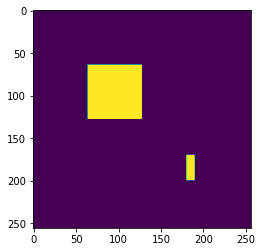

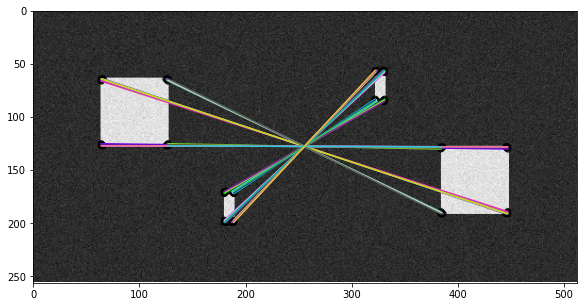

In [0]:
square = np.zeros((256,256))
square[64:128,64:128] = 1

square[170:200,180:190] = 1
plt.imshow(square)
plt.show()
square1 = square + np.random.randn(256,256)/20
square2 = square1[::-1,::-1]

descriptors1, keypoints1 = ORB(square1, npoints = 256, threshold = 0.25)
descriptors2, keypoints2 = ORB(square2, npoints = 256, threshold = 0.25)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
fig, ax = plt.subplots(figsize = (10,5))
plot_matches(ax, square1, square2, keypoints1, keypoints2, matches12)
plt.show()

## Combining Both

In [0]:
class ImageProcessor():

    def __init__(self, npoints = 256, threshold = 0.25, smooth = False):

        self.model = DepthEstimator()

        self.npoints = npoints
        self.threshold = threshold
        self.smooth = smooth

    def process(self, image):

        image, depth, top_margin, left_margin = self.model(image, return_margins = True)

        gray = np.mean(image,2)

        descriptors, keypoints = ORB(gray, npoints = self.npoints, threshold = self.threshold, smooth = self.smooth)

        return image, depth, descriptors, keypoints, top_margin, left_margin

processor = ImageProcessor(threshold = 0.4, npoints = 128, smooth = True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



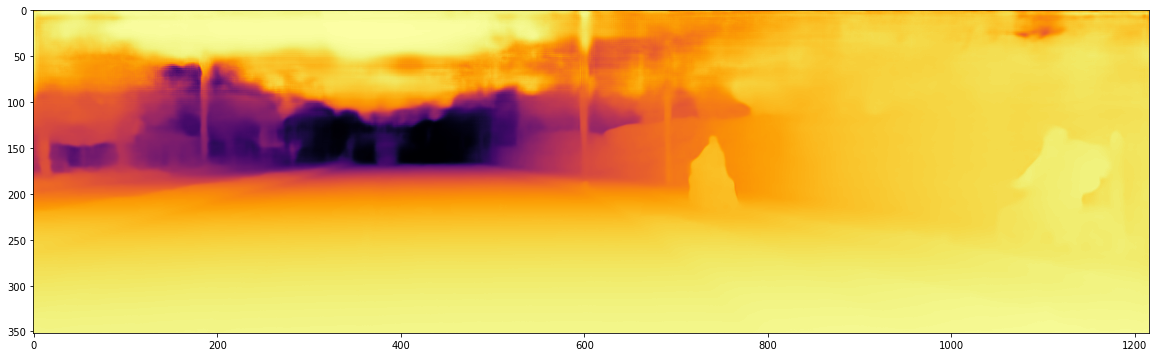

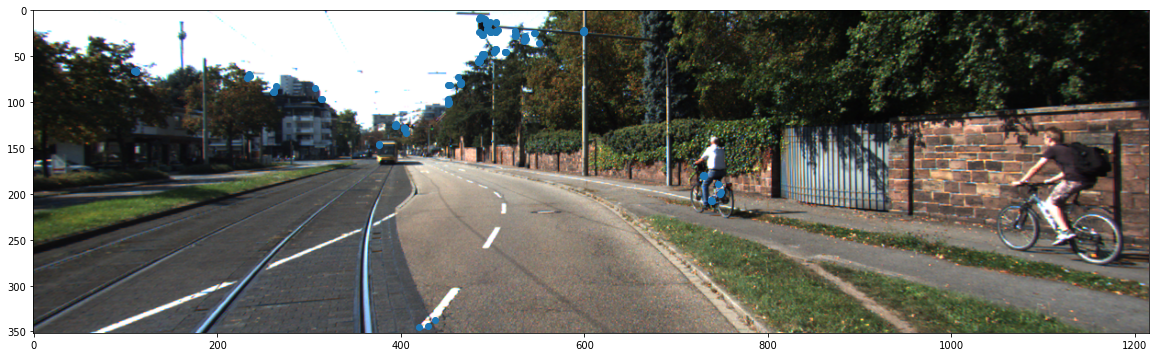

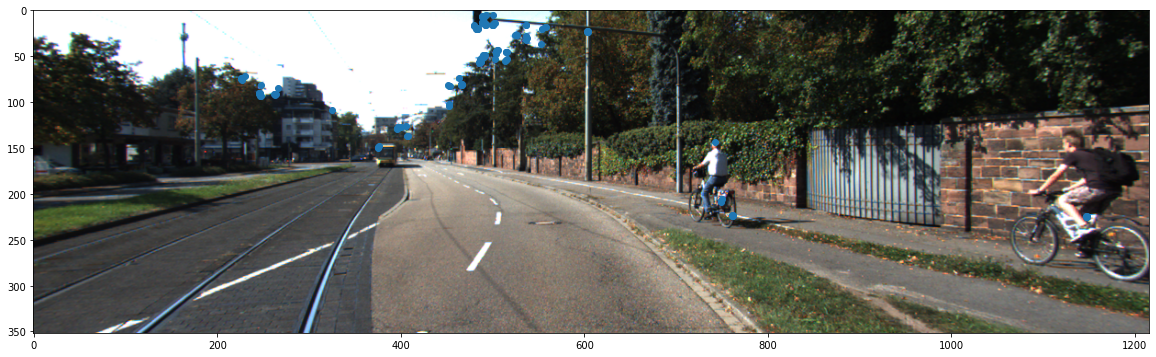

In [0]:
img_num = '05'
image_path = f'/content/2011_09_26/2011_09_26_drive_0002_sync/image_02/data/00000000{img_num}.png'
image = np.asarray(Image.open(image_path), dtype=np.float32) / 255.0


image1, depth1, descriptors1, keypoints1, top_margin1, left_margin1 = processor.process(image)

img_num = '07'
image_path = f'/content/2011_09_26/2011_09_26_drive_0002_sync/image_02/data/00000000{img_num}.png'
image = np.asarray(Image.open(image_path), dtype=np.float32) / 255.0

image2, depth2, descriptors2, keypoints2, top_margin2, left_margin2 = processor.process(image)

processor.model.plot_image(depth1)
plt.figure(figsize=(20,7))
plt.imshow(image1)
plt.scatter(keypoints1[:,1], keypoints1[:,0])
plt.show()

plt.figure(figsize=(20,7))
plt.imshow(image2)
plt.scatter(keypoints2[:,1], keypoints2[:,0])
plt.show()

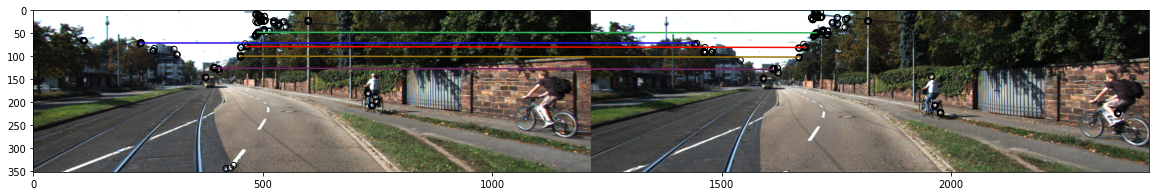

In [0]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1.astype(np.uint8),descriptors2.astype(np.uint8))
matches = sorted(matches, key = lambda x:x.distance)

match1 = np.array([match.queryIdx for match in matches])
match2 = np.array([match.trainIdx for match in matches])
matches12 = np.stack((match1, match2)).T

fig, ax = plt.subplots(figsize = (20,10))
plot_matches(ax, image1, image2, keypoints1, keypoints2, matches12[:5])
plt.show()

# Relative Pose Estimations

## Camera Parameters

In [0]:
# Camera Parameters
K_1 = np.array([[ 9.597910e+02, 0.000000e+00, 6.960217e+02],[ 0.000000e+00, 9.569251e+02, 2.241806e+02],[ 0.000000e+00, 0.000000e+00, 1.000000e+00]])
K_2 = np.array([[ 9.895267e+02, 0.000000e+00, 7.020000e+02],[ 0.000000e+00, 9.878386e+02, 2.455590e+02],[ 0.000000e+00, 0.000000e+00, 1.000000e+00]])
D_1 = np.array([-3.728755e-01, 2.037299e-01, 2.219027e-03, 1.383707e-03, -7.233722e-02])
# rotation and translation between cameras
R_stereo = np.array([[9.993513e-01, 1.860866e-02, -3.083487e-02],[ -1.887662e-02, 9.997863e-01, -8.421873e-03],[ 3.067156e-02, 8.998467e-03, 9.994890e-01]])
T_stereo = np.array([-5.370000e-01, 4.822061e-03, -1.252488e-02])

## 3d Projection

In [0]:
def extract_3d_points(keypoints, K, depth, top_off = 0, left_off = 0):
    wrld_pts = []
    for k in keypoints:
        d = depth[int(k[0]),int(k[1])]
        p = pixel_to_cam(k,K, top_off, left_off)
        p = p / np.linalg.norm(p)
        wrld_pts.append(p  *d)

    return np.array(wrld_pts)

def pixel_to_cam(px,K ,top_off = 0, left_off = 0):
    # print('top: ', top_off, ' left_off: ', left_off, px)
    p = np.array([px[1] + left_off, px[0] + top_off,1])
    return np.linalg.inv(K)@p

## Correspondences

In [0]:
def filter_for_pts_and_inliers(matches, num,kp1,kp2,des1,des2):
    pt1 = []
    pt2 = []
    kp1out = []
    kp2out = []
    des1out,des2out = [],[]
    for m in matches[:num]:
        pt1.append(kp1[m.queryIdx].pt)
        pt2.append(kp2[m.trainIdx].pt)
        kp1out.append(kp1[m.queryIdx])
        kp2out.append(kp2[m.trainIdx])
        des1out.append(des1[m.queryIdx])
        des2out.append(des2[m.trainIdx])
    return np.array(pt1),np.array(pt2),kp1out,kp2out,np.array(des1out),np.array(des2out)

def filter_by_matches(matches,val1,val2):
    val1out, val2out = [],[]
    for m in matches:
        if val1 is not None:
            val1out.append(val1[m.queryIdx])
        if val2 is not None:
            val2out.append(val2[m.trainIdx])
    return val1out if val1 is not None else None,val2out if val2 is not None else None

## Pose Estimator

In [0]:
import random 

def find_pose(set_one, set_two):
    
    set_one = set_one.T
    set_two = set_two.T
    if(set_one.shape != set_two.shape):
        print("BAD SETS to find_pose")
        
    centroid1 = np.mean(set_one,axis=1)
    centroid2 = np.mean(set_two,axis=1)
    
    centroid1 = centroid1.reshape((3,1))
    centroid2 = centroid2.reshape((3,1))

    q1 = set_one - centroid1
    q2 = set_two - centroid2
    
    H = (q1 @ q2.T)/set_one.shape[1]
    u,s,vh = np.linalg.svd(H)
    X = vh.T@u.T
    det = np.linalg.det(X)
    s = np.eye(3)
    s[2,2] = det
    
    X = vh.T @ s @ u.T
    T = centroid2 - X@centroid1

    return T, X

def RANSAC(set1,set2, num = 10, max_iter = 1000, tolerance = 0.2):
    #expects sets as points in the row, stacked along column
    max_in = 0
    R_best,t_best = 0,0
    inliers_best = 0
    norm_best = 0
    for i in range(max_iter):
        ind = random.sample(range(set1.shape[0]),num)
        # print('ransac sample: ', set1[ind],set2[ind])
        T,R = find_pose(set1[ind],set2[ind])
        inliers = np.linalg.norm((set2.T - (R@set1.T+T)).T,axis=1)<tolerance
        inlier_count = sum(inliers)
        if inlier_count > max_in:
            max_in = inlier_count
            R_best,t_best = R,T
            inliers_best = inliers
            norm_best = np.linalg.norm((set2[ind].T - (R@set1[ind].T+T)).T)
    
    print(sum(inliers_best), '/', len(set1))

    # # Uncomment to visualize Point Cloud Registration
    # df1 = pd.DataFrame(set2[::5])
    # # df1 = (df1-df1.mean())/df1.std()
    # df1['color'] = [1]*len(df1)
    # fig = px.scatter_3d(df1, x=0, y=1, z=2, color = 'color')
    # df2 = pd.DataFrame((R@set1.T+T).T[::5])
    # # df2 = (df2-df2.mean())/df2.std()
    # fig2 = px.scatter_3d(df2, x=0, y=1, z=2)
    # fig.add_trace(fig2.data[0])
    # fig.show()

    # print(max_in,inliers_best, R_best, t_best)
    print(R_best)
    print(t_best)
    print('norm best: ', norm_best)

    return R_best, t_best, inliers_best


## Utilities

In [0]:
def run_sequence(frames,K,num_pts):
    config = np.eye(4)
    hist = [config]
    c = 0

    processor = ImageProcessor(npoints = num_pts)
    for l_frame,c_frame in zip(frames[:-1],frames[1:]):
        print('------------')
        print("STEP: ",str(c))
        c+=1

        image1 = Image.open(l_frame)
        image2 = Image.open(c_frame)
        
        image1 = np.asarray(image1, dtype=np.float32) / 255.0
        image2 = np.asarray(image2, dtype=np.float32) / 255.0               
        
        image1, depth1, descriptors1, keypoints1, top_margin, left_margin = processor.process(image1)
        image2, depth2, descriptors2, keypoints2, top_margin, left_margin = processor.process(image2)
        
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(descriptors1.astype(np.uint8),descriptors2.astype(np.uint8))
        matches = sorted(matches, key = lambda x:x.distance)

        wrld_pts1 = extract_3d_points(keypoints1, K, depth1, top_margin, left_margin)
        wrld_pts2 = extract_3d_points(keypoints2, K, depth2, top_margin, left_margin)

        wrld_pt1,wrld_pt1_next = filter_by_matches(matches,wrld_pts1,wrld_pts2)

        R, T, outliers = RANSAC(np.array(wrld_pt1),np.array(wrld_pt1_next))
        trans = get_homo_trans(np.linalg.inv(R),-1*T)
        config = trans @ np.copy(config) 
        hist.append(config)
        
    return np.array(hist)     

def get_homo_trans(R,t):
    ret = np.eye(4)
    ret[:3,:3] = R
    ret[:3,3] = t.squeeze()
    return ret

def plot_path(hist):
    plt.xlim(-20,20)
    plt.ylim(0,40)
    plt.plot(hist[:,0,3],hist[:,2,3])
    plt.show()


# Monocular Visual Odometry

## Testing

------------
STEP:  0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 



25 / 504
[[ 0.99998288  0.00455314 -0.00367476]
 [-0.00453887  0.99998216  0.00388267]
 [ 0.00369237 -0.00386592  0.99998571]]
[[-0.06320468]
 [-0.076677  ]
 [ 0.00286022]]
norm best:  9.807279539124352
------------
STEP:  1
29 / 495
[[ 0.99999473  0.00120663 -0.00301295]
 [-0.0012224   0.99998553 -0.00523902]
 [ 0.00300658  0.00524267  0.99998174]]
[[ 0.02547539]
 [ 0.09173778]
 [-0.2188268 ]]
norm best:  17.867758509528656
------------
STEP:  2
40 / 514
[[ 0.99998527 -0.00487056 -0.00239441]
 [ 0.00486302  0.99998324 -0.00314245]
 [ 0.00240968  0.00313076  0.9999922 ]]
[[ 0.13328969]
 [ 0.06176999]
 [-0.884023  ]]
norm best:  15.55750081415663
------------
STEP:  3
30 / 505
[[ 0.99999833 -0.00116545 -0.00140733]
 [ 0.00116334  0.9999982  -0.00149956]
 [ 0.00140908  0.00149792  0.99999789]]
[[-0.04708435]
 [ 0.02709208]
 [-0.1625091 ]]
norm best:  14.005594384925361
------------
STEP:  4
40 / 524
[[ 9.99992869e-01  3.76710924e-03 -2.66334458e-04]
 [-3.76680049e-03  9.99992244e-01  1.1

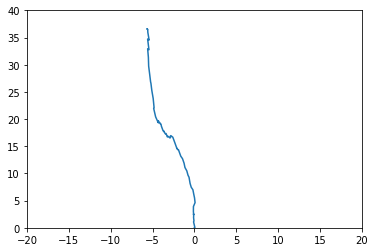

In [0]:
# Plot point cloud correspondences
frame_paths = ["/content/2011_09_26/2011_09_26_drive_0002_sync/image_02/data/"+str(i).zfill(10)+".png" for i in list(np.arange(75))]
hist = run_sequence(frame_paths,K_1,1024)
plot_path(hist)

## Video Generation from Frames

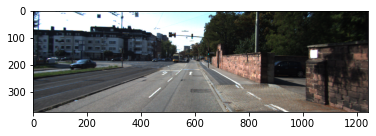

In [0]:
# Save Video of Car Motion for Reference
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
frame_paths = ["/content/2011_09_26/2011_09_26_drive_0002_sync/image_03/data/"+str(i).zfill(10)+".png" for i in np.arange(75)]

ims = []
for frame in frame_paths:
    image1 = Image.open(frame)
    im = plt.imshow(image1, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')

plt.show()

## Ground Truth Trajectory Calculation

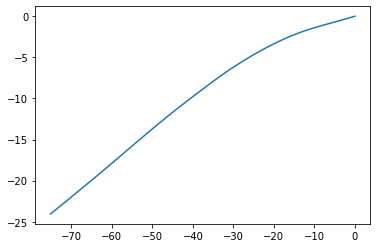

In [0]:
# Get Ground Truth Pose
def extract_pos(files):
    lat = []
    lon = []
    heading = []
    for file in files:
        f = open(file, 'r')
        content = f.readlines()
        for line in content:
            res = line.split()
            lat.append(float(res[0]))
            lon.append(float(res[1]))
            heading.append(float(res[4]))
    return lat,lon,heading

ground_truth = ["/content/2011_09_26/2011_09_26_drive_0002_sync/oxts/data/"+str(i).zfill(10)+".txt" for i in list(np.arange(75))]

lat,lon,heading = extract_pos(ground_truth)
lat,lon = (np.array(lat)-lat[0])*111209.9817808302,(np.array(lon)-lon[0])*73150.56741150614

plt.plot(lon,lat)
plt.show()